In [1]:
# -*- coding: utf-8 -*-
import cv2
import os
import sys
import random
import json
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import ipdb


In [2]:
file_list_json = "/home/liliang/test_jitter.json"
rf = open(file_list_json, "r")

label_info_save = {}
for line in rf:
    if len(line)<50:
        continue
    path, obj = line.split("\t")
    obj = json.loads(obj)
    label = obj["label"]
    _id = obj["id"]
    if not label in label_info_save:
        label_info_save[label] = {_id: path}
    else:
        label_info_save[label].update({_id: path})

In [3]:
from auto_deploy.predictor import Predictor

path_ori = "/world/data-gpu-112/liliang/pytorch-output-mt/v5+_resnet50_age10235_o10_s0.70.8_var0.8_v9+/resnet_50_ibn_a_20190805_153839.pt"
path_jit = "/world/data-gpu-112/liliang/pytorch-output-mt/v5+_resnet101_invar3_age10235_o10_s0.70.8_var0.8_v9+/resnet_101_ibn_a_20190816_143948.pt"
preprocess_dict = {"norm_lambda": "lambda x: x", "color_mode": "RGB"}
input_size = (128, 256)
predictor_ori = Predictor(gpu=0, input_size=input_size, model_path=path_ori, preprocess_dict=preprocess_dict)
predictor_jit = Predictor(gpu=1, input_size=input_size, model_path=path_jit, preprocess_dict=preprocess_dict)

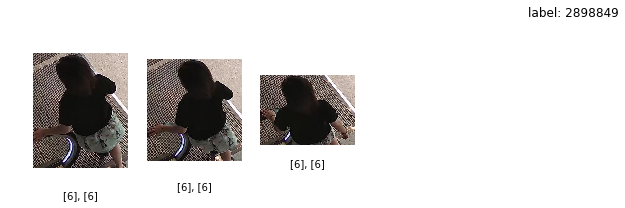

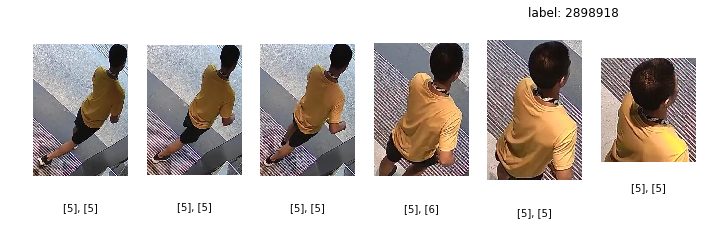

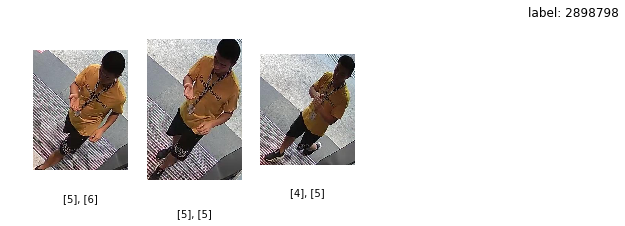

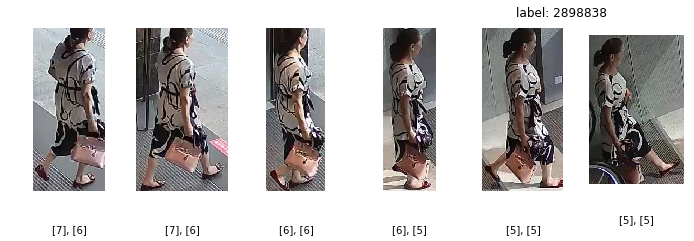

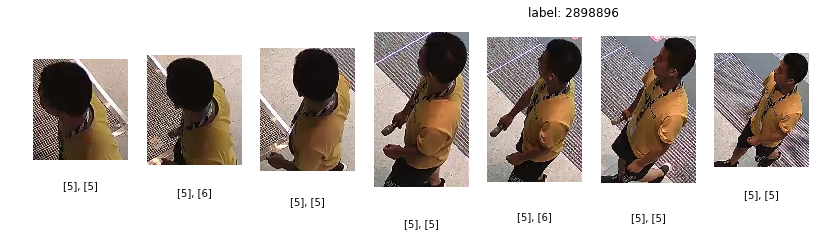

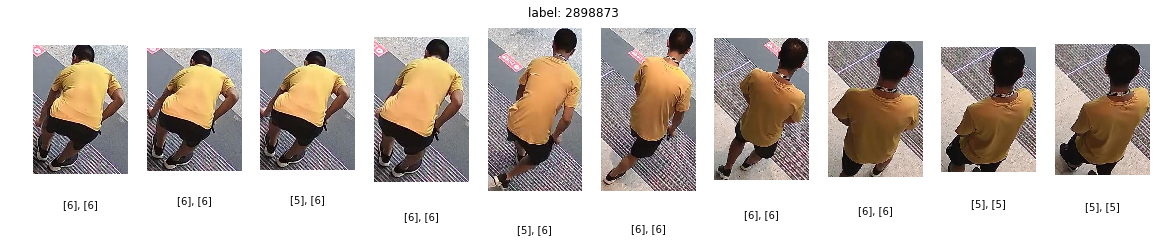

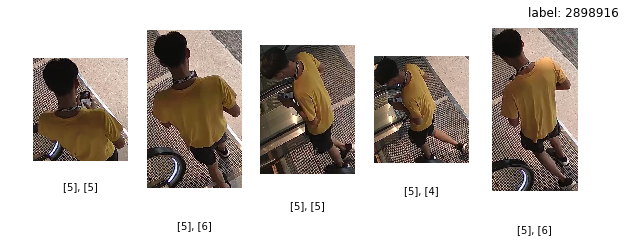

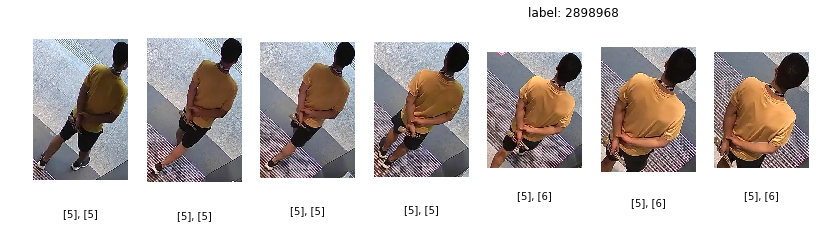

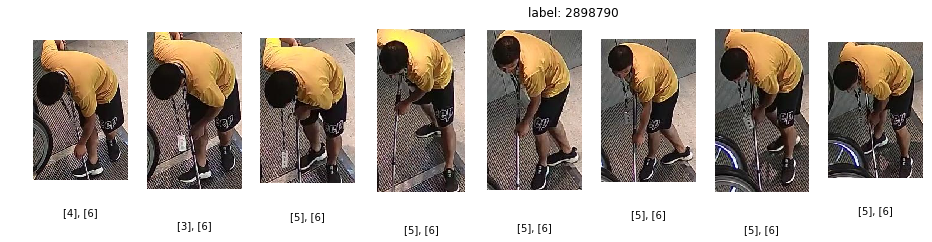

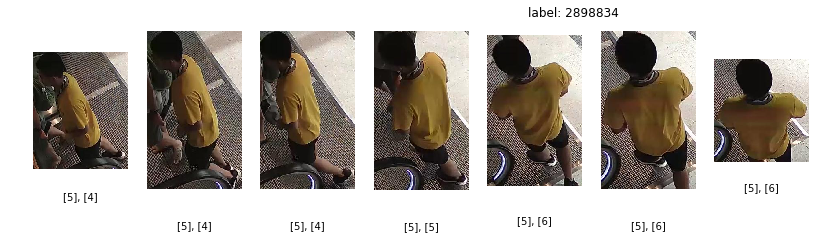

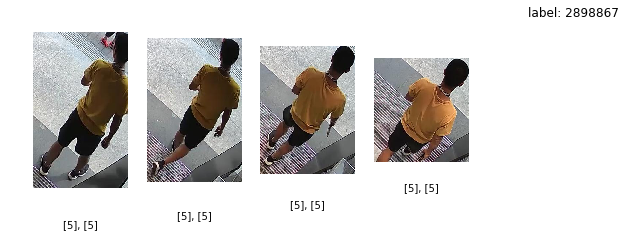

In [4]:
max_q_labels = 50
max_q_id = 10
max_draw = 10

rdn_labels = np.random.choice(list(label_info_save.keys()), size=max_q_labels, replace=False)
idx=0
for label in rdn_labels:
    if idx>max_draw:
        break
    plt.figure(idx, figsize=(20, 3))
    idx+=1
    plt.suptitle("label: "+str(label), horizontalalignment='center')
    n_topk = len(label_info_save[label])
    
    for k, _id_info in enumerate(label_info_save[label].items()):
        _id, path = _id_info
        img = cv2.imread(path)
        rets_ori = predictor_ori.predict([img])[1]
        rets_ori = np.asarray(rets_ori)
        pred_age_ori = np.argmax(rets_ori, axis=1).tolist()
        
        rets_jit = predictor_jit.predict([img])[1]
        rets_jit = np.asarray(rets_jit)      
        pred_age_jit = np.argmax(rets_jit, axis=1).tolist()
        
        if k>9:
            break
        plt.subplot(1, 10, k+1)
        img = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)
#         img = cv2.resize(img, (128, 256),
#                      interpolation=cv2.INTER_CUBIC)
        plt.imshow(img)
        plt.text(img.shape[1]/2, img.shape[0]*1.2, "%s, %s"%(pred_age_ori, pred_age_jit) , verticalalignment="top", horizontalalignment="center")
        plt.axis('off')
        